In [1]:
import os
%cd /home/ltchen/gnnpp
import sys
import json
import wandb
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.optim import AdamW
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.loader import DataLoader
from utils.data122 import *
# from utils.data import *
from exploration.graph_creation import *
from exploration.get_graphs_and_data import *
from utils.plot import plot_map
import utils


/home/ltchen/gnnpp


In [2]:
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()
print(DIRECTORY)
FIGUREPATH = os.path.join(DIRECTORY, 'figures')
os.makedirs(FIGUREPATH, exist_ok=True)



# JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name)

/home/ltchen/gnnpp


In [4]:
leadtime = "24h"
graph_name = "g5"
g_train_rf, g_valid_rf, g_test_rf, g_test_f = get_train_valid_graph_data(leadtime=leadtime, graph_name=graph_name)
facts_about(g_train_rf[0])

[INFO] Loading precomputed graph data on g5...


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(train_path)
/tmp/pycharm_project_408/ex

Successfully loaded precomputed data.
Number of nodes: 120 with feature dimension of x: 65
Number of isolated nodes: 2
Number of edges: 1608 with edge dimension: 7
Average node degree: 13.399999618530273


/tmp/pycharm_project_408/exploration/get_graphs_and_data.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_f = torch.load(test_f_path)


In [11]:
e_idx = g_train_rf[0].edge_index.numpy()
e_attr = g_train_rf[0].edge_attr.numpy()
# e_idx
first = np.where((e_idx[0] == 0) & (e_idx[1] == 4))[0]
second = np.where((e_idx[0] == 4) & (e_idx[1] == 0))[0]
second
print(e_attr[first,:])
print(e_attr[second,:])

[[ 0.16820976  0.0005586   0.0527841  -0.1752933  -0.00381436  0.3186039
   0.14178981]]
[[ 0.16820976 -0.0005586  -0.0527841   0.1752933   0.00381436  0.3186039
   0.14178981]]


In [12]:
leadtime = "24h"
dataframes = utils.data122.load_dataframes_old(mode="eval", leadtime=leadtime)
dataframes = summary_statistics(dataframes)

train = dataframes["train"][0]
train_target = dataframes["train"][1]
test_rf = dataframes["test_rf"][0]
test_rf_target = dataframes["test_rf"][1]
test_f = dataframes["test_f"][0]
test_f_target = dataframes["test_f"][1]
stations = dataframes["stations"]
dataframes['train'][0].nunique()

[INFO] Dataframes exist. Will load pandas dataframes.
[INFO] Calculating summary statistics for train
[INFO] Calculating summary statistics for test_rf
[INFO] Calculating summary statistics for test_f


time                  2612
station_id             122
model_orography        116
station_altitude       118
station_latitude       122
                     ...  
v_mean              306905
v_std               308216
t_mean              248620
t_std               308216
number                   1
Length: 65, dtype: int64

In [6]:
g = create_one_graph(df_train=train,
                     df_target=train_target,
                     station_df=stations,
                     attributes=["geo", "alt-orog", "dist3"],
                     edges=[("geo", 50), ("alt-orog", 1.5)],
                     date = "1997-01-02",
                     sum_stats = True,
                     leadtime=leadtime)
facts_about(g)

[INFO] Loading distances from file...


RuntimeError: The expanded size of the tensor (122) must match the existing size (120) at non-singleton dimension 1.  Target sizes: [122, 122].  Tensor sizes: [120, 120]

In [14]:
706-342 -392

-28

In [14]:
dataframes['train'][0].nunique()

time                  2612
station_id             122
model_orography        116
station_altitude       118
station_latitude       122
                     ...  
v_mean              306905
v_std               308216
t_mean              248620
t_std               308216
number                   1
Length: 65, dtype: int64

In [8]:
print(train.groupby(["time", "station_id"]).mean()["t2m_mean"])
print(train_target[train_target["station_id"] == 62].groupby(["time", "station_id"]).mean()["t2m"])

time        station_id
1997-01-02  0             279.183807
            1             278.898285
            2             278.370850
            3             277.342896
            4             278.731567
                             ...    
2009-12-31  117           283.422699
            118           274.349762
            119           271.944794
            120           267.208282
            121           262.805878
Name: t2m_mean, Length: 318664, dtype: float32
time        station_id
1997-01-02  62           NaN
1997-01-05  62           NaN
1997-01-09  62           NaN
1997-01-12  62           NaN
1997-01-16  62           NaN
                          ..
2009-12-24  62           NaN
2009-12-25  62           NaN
2009-12-27  62           NaN
2009-12-28  62           NaN
2009-12-31  62           NaN
Name: t2m, Length: 2612, dtype: float64


In [9]:
print(f"Number of NaN in t2m of station 62: \n{train_target[train_target['station_id'] == 62].isna().sum()}")
print(f"Number of total values of station 62: {train_target[train_target['station_id'] == 62].shape[0]}\n")

print(f"Number of NaN in t2m of station 74: \n{train_target[train_target['station_id'] == 74].isna().sum()}")
print(f"Number of total values of station 74: {train_target[train_target['station_id'] == 74].shape[0]}")

print(f"Number of NaN in t2m of station 74: \n{train_target[train_target['station_id'] == 74]['t2m'].isna().sum()}")

Number of NaN in t2m of station 62: 
time             0
station_id       0
t2m           2612
dtype: int64
Number of total values of station 62: 2612

Number of NaN in t2m of station 74: 
time             0
station_id       0
t2m           2612
dtype: int64
Number of total values of station 74: 2612
Number of NaN in t2m of station 74: 
2612


In [19]:
stations.iloc[61]

station_id                      61
lat                        49.7177
lon                         9.0997
altitude                     453.0
orog                    313.029401
name          Michelstadt-Vielbrun
Name: 61, dtype: object

## Plot map with nan as color code

In [13]:
nan_values = np.empty((122))
share_nan = np.empty((122))
for i in range(122):
    nan_values[i] = train_target[train_target['station_id'] == i]['t2m'].isna().sum().astype(int)
    share_nan[i] = train_target[train_target['station_id'] == i]['t2m'].isna().sum().astype(int) / train_target[train_target['station_id'] == i]['t2m'].shape[0]

# print(nan_values)
print("[" + "  ".join([f"{x:.1f}" for x in nan_values]) + "]")

# print(np.argwhere(nan_values == 2426))
print("[" + "  ".join([f"{x:.1f}" for x in share_nan]) + "]")



[0.0  0.0  24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  722.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  8.0  2.0  0.0  16.0  20.0  4.0  0.0  9.0  0.0  0.0  2.0  2.0  52.0  2.0  1.0  0.0  0.0  2.0  0.0  4.0  4.0  10.0  2.0  0.0  1.0  1.0  4.0  1.0  3.0  0.0  1.0  2.0  2612.0  0.0  0.0  1.0  0.0  6.0  1.0  3.0  1.0  0.0  13.0  3.0  2612.0  0.0  4.0  0.0  1.0  1.0  1.0  2.0  7.0  36.0  218.0  26.0  100.0  22.0  1590.0  594.0  4.0  5.0  9.0  0.0  12.0  7.0  29.0  51.0  11.0  80.0  32.0  602.0  70.0  4.0  6.0  16.0  605.0  8.0  36.0  164.0  0.0  1534.0  1.0  2.0  0.0  2.0  0.0  0.0  2.0  1.0  2.0  18.0]
[0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

<Figure size 600x600 with 0 Axes>

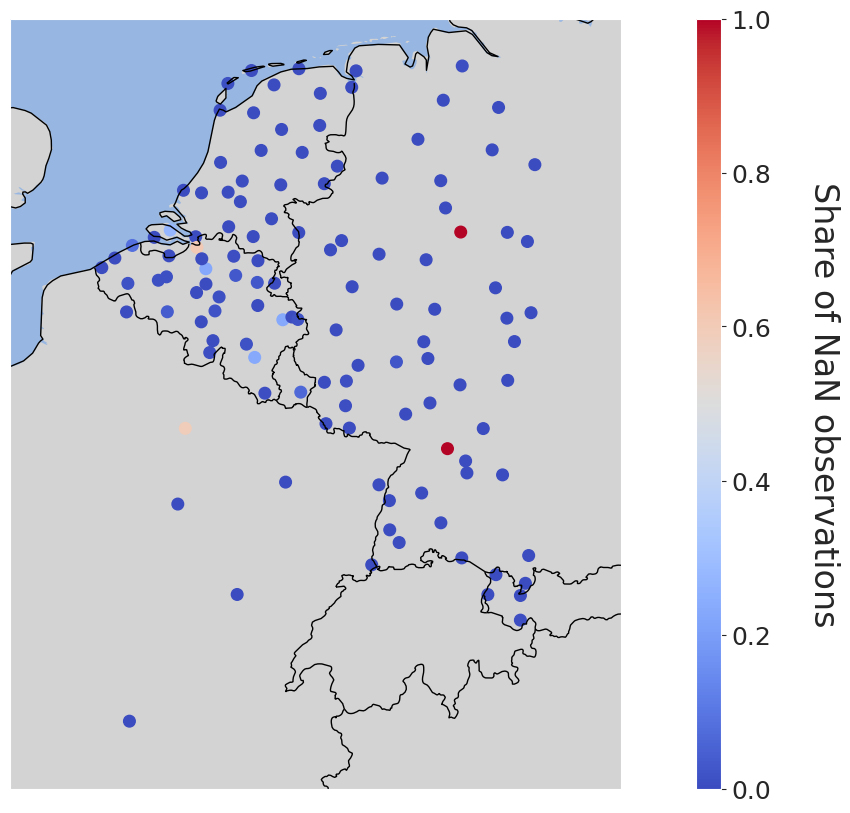

In [14]:
plt.figure(1, figsize=(6, 6))
ax = plot_map()

plot = ax.scatter(stations['lon'], stations['lat'], c=share_nan, cmap='coolwarm', s=70)
norm = plt.Normalize(vmin=min(share_nan), vmax=max(share_nan))
sm_nodes = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.08)
#colbar.ax.set_ylabel(r'$\mathrm{Number of NaN values}$', rotation=270, labelpad=20)
colbar.ax.set_ylabel('Share of NaN observations', rotation=270, labelpad=50, fontsize=24)
colbar.ax.tick_params(labelsize=18)
plt.savefig(os.path.join(FIGUREPATH, "eda/nan_map.png"), bbox_inches = 'tight', dpi=300)

In [44]:
stations.sort_values(by='lat', ascending=True)[:10]

,station_id,lat,lon,altitude,orog,name
117,117,45.786833,3.149333,331.00,521.714299,Clermont-Fd
121,121,46.968056,10.185555,1587.00,2105.435549,Galtuer
120,120,47.255833,10.186111,1478.00,1752.460782,Warth
119,119,47.266666,9.600000,439.00,972.938723,Feldkirch
115,115,47.267833,5.088333,219.00,310.786025,Dijon-Longvic
64,64,47.398400,10.275900,805.76,1195.644744,Oberstdorf
118,118,47.499168,9.746111,424.00,689.253673,Bregenz
116,116,47.614333,7.510000,263.00,450.385150,Bale-Mulhouse
54,54,47.695200,9.130700,428.06,500.912088,Konstanz
49,49,47.723300,10.334800,705.20,821.714809,Kempten


<Figure size 1000x1000 with 0 Axes>

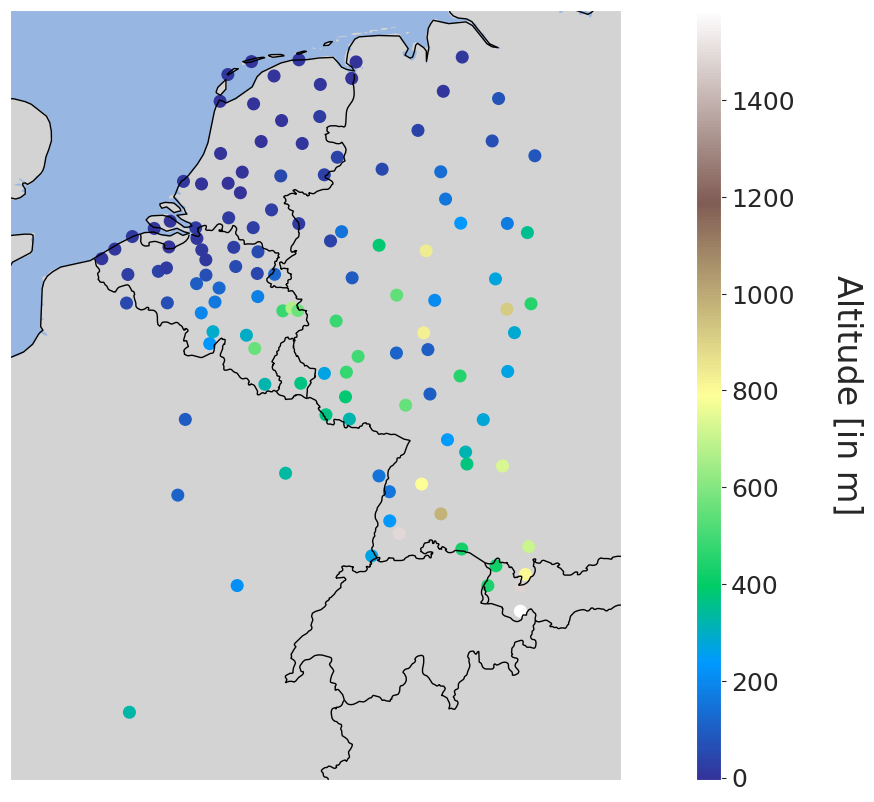

In [15]:
FIGUREPATH = os.path.join(DIRECTORY, 'figures')
os.makedirs(FIGUREPATH, exist_ok=True)
plt.figure(1, figsize=(10, 10))
ax = plot_map()

plot = ax.scatter(stations['lon'], stations['lat'],  c=stations['altitude'], cmap='terrain', s=70)
norm = plt.Normalize(vmin=min(stations['altitude']), vmax=max(stations['altitude']))
sm_nodes = plt.cm.ScalarMappable(cmap="terrain", norm=norm)
colbar = plt.colorbar(sm_nodes, ax=ax, aspect=30, pad=0.08)
#colbar.ax.set_ylabel(r'$\mathrm{Number of NaN values}$', rotation=270, labelpad=20)
colbar.ax.set_ylabel('Altitude [in m]', rotation=270, labelpad=50, fontsize=24)
colbar.ax.tick_params(labelsize=18)
# ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
# ax.set_rasterized(True)
## Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))

plt.savefig(os.path.join(FIGUREPATH, "eda/altitude_map.png"), bbox_inches = 'tight', dpi=300)

## Distribution of distances

In [7]:
stations

,station_id,lat,lon,altitude,orog,name
0,0,52.928000,4.781000,1.2,-1.706008,De Kooy
1,1,52.318000,4.790000,-3.3,-1.298122,Schiphol
2,2,53.241000,4.921000,10.8,0.333424,Vlieland
3,3,53.392000,5.346000,0.7,1.302155,Hoorn (Terschelling)
4,4,52.100000,5.180000,1.9,2.576800,De Bilt
...,...,...,...,...,...,...
117,117,45.786833,3.149333,331.0,521.714299,Clermont-Fd
118,118,47.499168,9.746111,424.0,689.253673,Bregenz
119,119,47.266666,9.600000,439.0,972.938723,Feldkirch
120,120,47.255833,10.186111,1478.0,1752.460782,Warth


In [16]:
geo_mat = compute_mat(station_df=stations, mode="geo", sum_stats=True)
alt_mat = compute_mat(station_df=stations, mode="alt", sum_stats=True)
orog_mat = compute_mat(station_df=stations, mode="alt-orog", sum_stats=True)
d2mat = load_d2_distances(stations=stations, train_set=train, sum_stats=True, leadtime=leadtime)
rounded2 = d2mat.flatten()
d3mat = load_d3_distances(stations=stations, train_set=train, train_target_set=train_target, sum_stats=True, leadtime=leadtime)
rounded3 = d3mat.flatten()
d4mat = compute_mat(station_df=stations, mode="dist4", sum_stats=True, train_set=train, train_target_set=train_target, leadtime=leadtime)

[INFO] Loading distances from file...
[INFO] Loading distances from file...
[INFO] Loading distances from file...
[INFO] Loading distances from file...


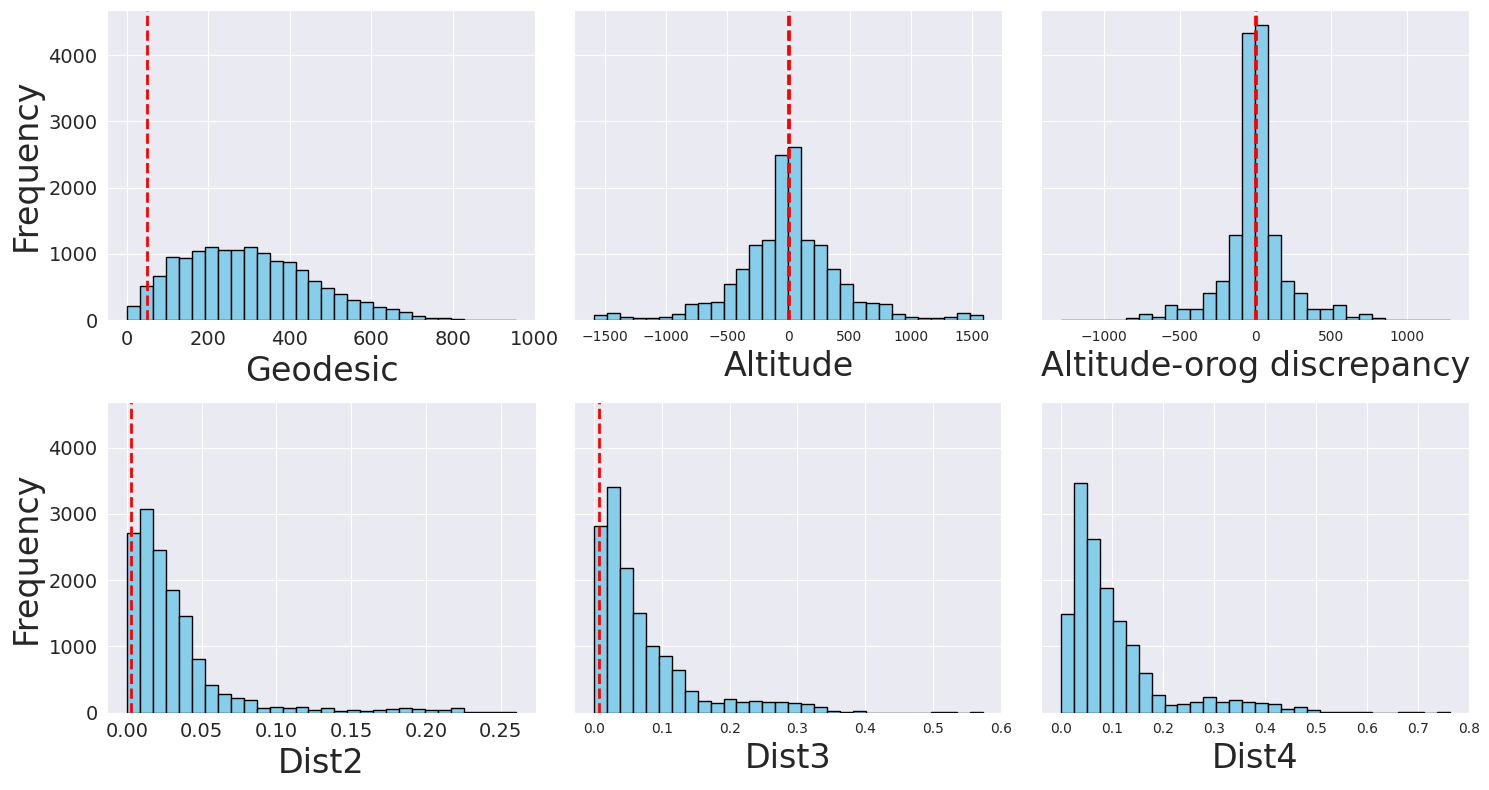

In [12]:
import matplot2tikz
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

axes[0].hist(geo_mat.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[0].axvline([50], color='red', linestyle='--', linewidth=2)
# axes[0].set_title(f"Histogram of geodesic distances", fontsize=24)
axes[0].set_xlabel('Geodesic', fontsize=24)
axes[0].tick_params(labelsize=14)
axes[0].set_ylabel('Frequency', fontsize=24)

axes[1].hist(alt_mat.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[1].axvline([-4], color='red', linestyle='--', linewidth=2)
axes[1].axvline([4], color='red', linestyle='--', linewidth=2)
# axes[1].set_title(f"Histogram of altitude distances")
axes[1].set_xlabel('Altitude', fontsize=24)
# axes[1].set_ylabel('Frequency', fontsize=24)

axes[2].hist(orog_mat.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[2].axvline([-1.5], color='red', linestyle='--', linewidth=2)
axes[2].axvline([1.5], color='red', linestyle='--', linewidth=2)
# axes[2].set_title(f"Histogram of altitude-orog distances")
axes[2].set_xlabel('Altitude-orog discrepancy', fontsize=24)
# axes[2].set_ylabel('Frequency', fontsize=24)

axes[3].hist(d2mat.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[3].axvline([0.003], color='red', linestyle='--', linewidth=2)
# axes[3].set_title(f"Histogram of dist2 distances")
axes[3].tick_params(labelsize=14)
axes[3].set_xlabel('Dist2', fontsize=24)
axes[3].set_ylabel('Frequency', fontsize=24)

axes[4].hist(d3mat.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[4].axvline([0.0074], color='red', linestyle='--', linewidth=2)
# axes[4].set_title(f"Histogram of dist3 distances")
axes[4].set_xlabel('Dist3', fontsize=24)
# axes[4].set_ylabel('Frequency', fontsize=24)

axes[5].hist(d4mat.flatten(), bins=30, color='skyblue', edgecolor='black')
# axes[5].set_title(f"Histogram of dist4 distances")
axes[5].set_xlabel('Dist4', fontsize=24)
# axes[5].set_ylabel('Frequency', fontsize=24)

plt.tight_layout()
# plt.savefig(os.path.join(FIGUREPATH, "methodology/distmetrics_histograms_biggerFont.pdf"), bbox_inches = 'tight', dpi=300)
matplot2tikz.save(os.path.join(FIGUREPATH, "methodology/distmetrics_histograms_biggerFont.pdf"), dpi=300)
plt.show()
print(FIGUREPATH)

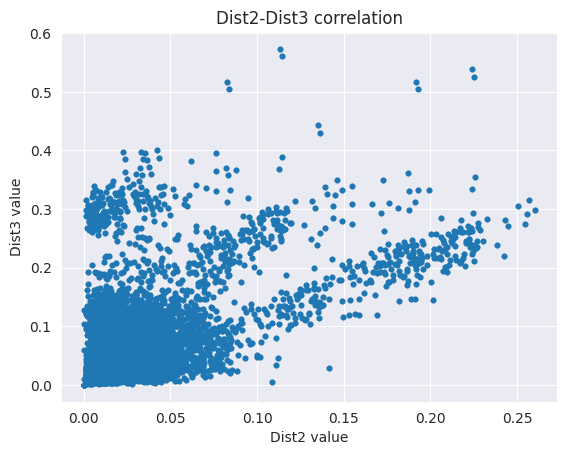

In [17]:
plt.scatter(rounded2, rounded3, color='#1f77b4', s=10, label='Actual')
x_values = [min(rounded2), max(rounded2)]
y_values = [min(rounded3), max(rounded3)]
# plt.plot(x_values, y_values, color='red', label='Perfectly correlated')
plt.title('Dist2-Dist3 correlation')
plt.xlabel('Dist2 value')
plt.ylabel('Dist3 value')
# plt.legend()
plt.savefig(os.path.join(FIGUREPATH, "dist2_dist3_corr.pdf"), bbox_inches = 'tight')
plt.show()
# which are the point for station 62 and 74?